In [ ]:
import trace_IO as tio
import OF_trigger as of
import Joint_OF as jof
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
templates = [ch45_template] + [ch46_template] *8     # template: 1D array, e.g., (32768,)
psds = [noise_psd] * 9         # noise_psd: 1D array, e.g., (16385,)

# Initialize Optimum Filter
OF = of.OFtrigger(template, noise_psd, sampling_frequency)

JOF = jof.JointChannelOF(templates, psds, sampling_frequency)



In [ ]:
#just the roc and trigger efficiency of two type of triggers on NR events
#and the ampl distribution of fixed Joint OF on vacumm

In [ ]:
OF = of.OFtrigger(template, noise_psd, sampling_frequency)


In [11]:
loaded_traces = tio.load_traces_from_zstd(f"/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)

In [12]:
loaded_traces.shape

(1000, 54, 32768)

Processing traces: 100%|██████████| 1000/1000 [01:13<00:00, 13.54it/s]


Amplitude Statistics Using CH45 Template:
Mean: -0.0009
Std: 0.8494
Min: -2.5000
Max: 2.4709

Amplitude Statistics Using CH46 Template:
Mean: 0.0021
Std: 0.7605
Min: -2.0952
Max: 2.1477


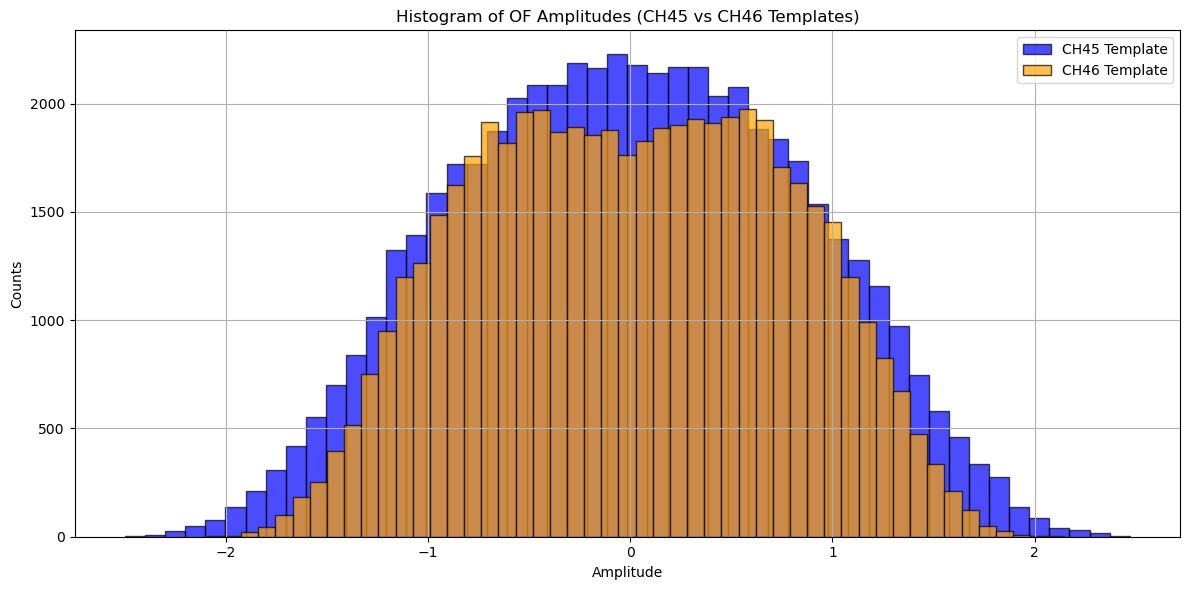

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import OF_trigger as of

# Constants
sampling_frequency = 3906250

# Load templates and PSD
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize individual OF objects
OF_ch45 = of.OFtrigger(ch45_template, noise_psd, sampling_frequency)
OF_ch46 = of.OFtrigger(ch46_template, noise_psd, sampling_frequency)

# Assume loaded_traces is available in the environment with shape (1000, 54, 32768)
amplitudes_ch45 = []
amplitudes_ch46 = []

for i in tqdm(range(1000), desc="Processing traces"):
    for ch in range(54):
        trace = loaded_traces[i][ch]
        amp_45, *_ = OF_ch45.fit(trace)
        amp_46, *_ = OF_ch46.fit(trace)
        amplitudes_ch45.append(amp_45)
        amplitudes_ch46.append(amp_46)

# Convert to numpy arrays
amplitudes_ch45 = np.array(amplitudes_ch45)
amplitudes_ch46 = np.array(amplitudes_ch46)

# Calculate statistics
print("Amplitude Statistics Using CH45 Template:")
print(f"Mean: {np.mean(amplitudes_ch45):.4f}")
print(f"Std: {np.std(amplitudes_ch45):.4f}")
print(f"Min: {np.min(amplitudes_ch45):.4f}")
print(f"Max: {np.max(amplitudes_ch45):.4f}\n")

print("Amplitude Statistics Using CH46 Template:")
print(f"Mean: {np.mean(amplitudes_ch46):.4f}")
print(f"Std: {np.std(amplitudes_ch46):.4f}")
print(f"Min: {np.min(amplitudes_ch46):.4f}")
print(f"Max: {np.max(amplitudes_ch46):.4f}")

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(amplitudes_ch45, bins=50, alpha=0.7, label='CH45 Template', color='blue', edgecolor='black')
plt.hist(amplitudes_ch46, bins=50, alpha=0.7, label='CH46 Template', color='orange', edgecolor='black')
plt.title('Histogram of OF Amplitudes (CH45 vs CH46 Templates)')
plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies:   0%|          | 0/30 [00:00<?, ?it/s]

Processing energies: 100%|██████████| 30/30 [02:46<00:00,  5.55s/it]


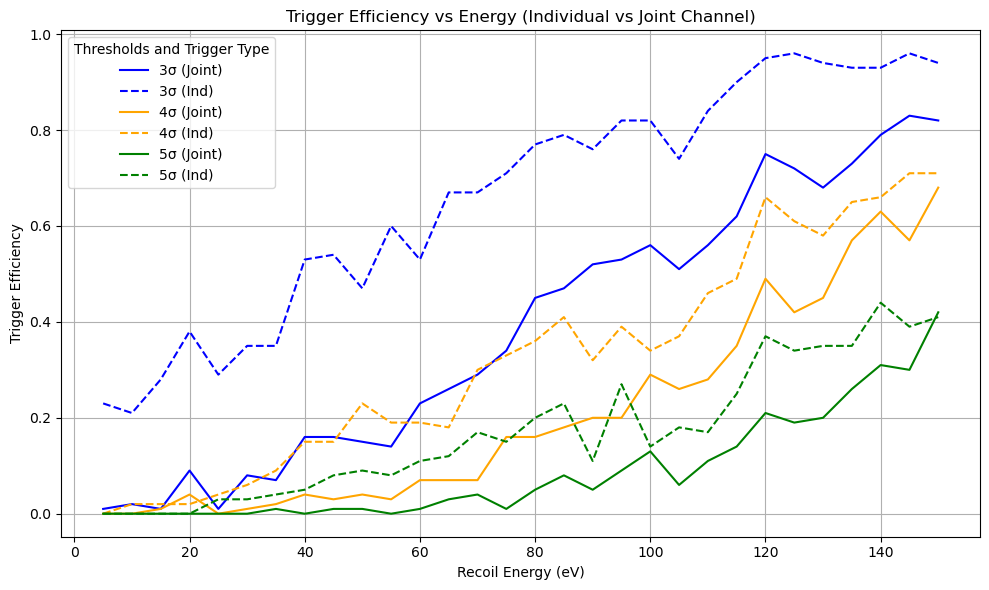

In [8]:
import trace_IO as tio
import OF_trigger as of
import Joint_OF as jof
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zstandard as zstd
import io


# Constants
sampling_frequency = 3906250
sigma_individual = 0.7674
sigma_joint = 2.2453
thresholds_individual = [round(n * sigma_individual, 4) for n in [3, 4, 5]]
thresholds_joint = [round(n * sigma_joint, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 151, 5))
sigma_labels_ind = {thresholds_individual[0]: '3σ (Ind)', thresholds_individual[1]: '4σ (Ind)', thresholds_individual[2]: '5σ (Ind)'}
sigma_labels_joint = {thresholds_joint[0]: '3σ (Joint)', thresholds_joint[1]: '4σ (Joint)', thresholds_joint[2]: '5σ (Joint)'}

# Load templates and PSDs
template = np.load("../templates/template_K_alpha_no_baseline.npy")
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
templates = [ch45_template] + [ch46_template] * 8
psds = [noise_psd] * 9

# Initialize filters
OF = of.OFtrigger(template, noise_psd, sampling_frequency)
JOF = jof.JointChannelOF(templates, psds, sampling_frequency)

# Storage
pass_rates_individual = {th: [] for th in thresholds_individual}
pass_rates_joint = {th: [] for th in thresholds_joint}

# Main loop
for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces = tio.load_traces_from_zstd(trace_path, n_traces=100)  # shape: (100, 54, 32768)

    max_individual_amplitudes = []
    joint_amplitudes = []

    for i in range(100):
        traces_tail = loaded_traces[i][45:]  # Use only channels 45 to 53

        # Individual channel trigger
        amps = [OF.fit_with_shift(trace)[0] for trace in traces_tail]
        max_individual_amplitudes.append(max(amps))

        # Joint channel trigger
        joint_amp, _, _ = JOF.fit_with_shift(traces_tail)
        joint_amplitudes.append(joint_amp)

    max_individual_amplitudes = np.array(max_individual_amplitudes)
    joint_amplitudes = np.array(joint_amplitudes)

    for th in thresholds_individual:
        pass_rate = np.sum(max_individual_amplitudes > th) / 100
        pass_rates_individual[th].append(pass_rate)

    for th in thresholds_joint:
        pass_rate = np.sum(joint_amplitudes > th) / 100
        pass_rates_joint[th].append(pass_rate)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for i, (th_ind, th_joint) in enumerate(zip(thresholds_individual, thresholds_joint)):
    color = colors[i]
    plt.plot(energy_values, pass_rates_joint[th_joint], linestyle='-', color=color, label=sigma_labels_joint[th_joint])
    plt.plot(energy_values, pass_rates_individual[th_ind], linestyle='--', color=color, label=sigma_labels_ind[th_ind])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Trigger Efficiency')
plt.title('Trigger Efficiency vs Energy (Individual vs Joint Channel)')
plt.legend(title='Thresholds and Trigger Type')
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies: 100%|██████████| 30/30 [02:53<00:00,  5.77s/it]


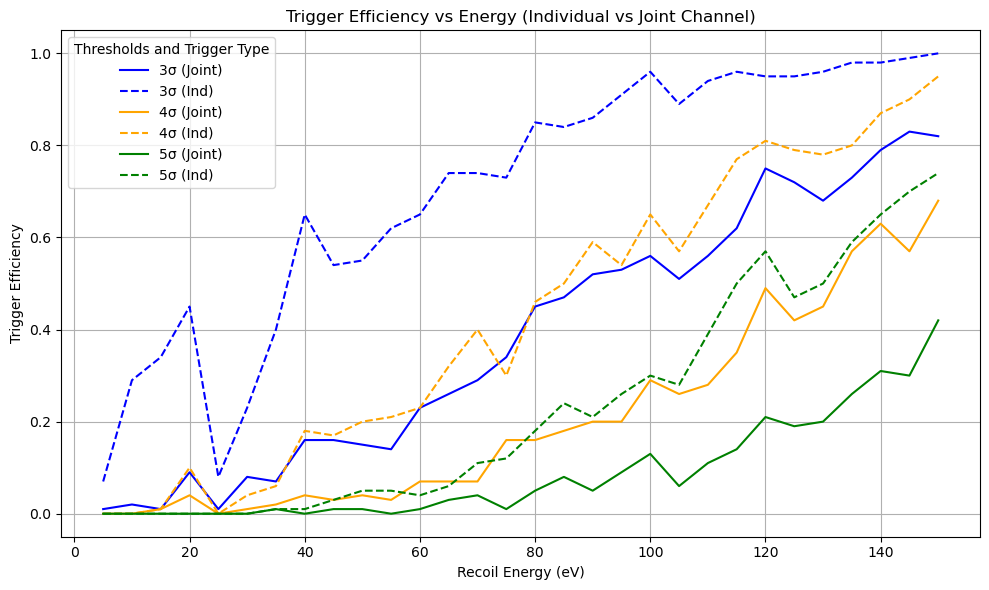

In [14]:
import trace_IO as tio
import OF_trigger as of
import Joint_OF as jof
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
sampling_frequency = 3906250
sigma_ch45 = 0.8494
sigma_ch46plus = 0.7605
sigma_joint = 2.2453

# Individual thresholds based on per-channel sigma
thresholds_individual = [
    round(min(0.8494, 0.7605) * n, 4) for n in [3, 4, 5]  # conservative choice
]
thresh_labels_ind = {thresholds_individual[0]: '3σ (Ind)', thresholds_individual[1]: '4σ (Ind)', thresholds_individual[2]: '5σ (Ind)'}
thresh_labels_joint = {round(n * sigma_joint, 4): f'{n}σ (Joint)' for n in [3, 4, 5]}
thresholds_joint = list(thresh_labels_joint.keys())

energy_values = list(range(5, 151, 5))

# Load templates and PSDs
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
templates = [ch45_template] + [ch46_template] * 8
psds = [noise_psd] * 9

# Initialize filters
OF_ch45 = of.OFtrigger(ch45_template, noise_psd, sampling_frequency)
OF_ch46 = of.OFtrigger(ch46_template, noise_psd, sampling_frequency)
JOF = jof.JointChannelOF(templates, psds, sampling_frequency)

# Storage
pass_rates_individual = {th: [] for th in thresholds_individual}
pass_rates_joint = {th: [] for th in thresholds_joint}

# Main loop
for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces = tio.load_traces_from_zstd(trace_path, n_traces=100)  # shape: (100, 54, 32768)

    max_individual_amps = []
    joint_amps = []

    for i in range(100):
        traces = loaded_traces[i][45:]  # channels 45 to 53

        # Individual channel trigger (use appropriate template)
        amps = [OF_ch45.fit_with_shift(trace)[0] if ch == 0 else OF_ch46.fit_with_shift(trace)[0] for ch, trace in enumerate(traces)]
        max_individual_amps.append(max(amps))

        # Joint trigger
        joint_amp, _, _ = JOF.fit_with_shift(traces)
        joint_amps.append(joint_amp)

    max_individual_amps = np.array(max_individual_amps)
    joint_amps = np.array(joint_amps)

    for th in thresholds_individual:
        pass_rates_individual[th].append(np.sum(max_individual_amps > th) / 100)

    for th in thresholds_joint:
        pass_rates_joint[th].append(np.sum(joint_amps > th) / 100)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for i, (th_ind, th_joint) in enumerate(zip(thresholds_individual, thresholds_joint)):
    color = colors[i]
    plt.plot(energy_values, pass_rates_joint[th_joint], linestyle='-', color=color, label=thresh_labels_joint[th_joint])
    plt.plot(energy_values, pass_rates_individual[th_ind], linestyle='--', color=color, label=thresh_labels_ind[th_ind])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Trigger Efficiency')
plt.title('Trigger Efficiency vs Energy (Individual vs Joint Channel)')
plt.legend(title='Thresholds and Trigger Type')
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies: 100%|██████████| 30/30 [05:18<00:00, 10.60s/it]


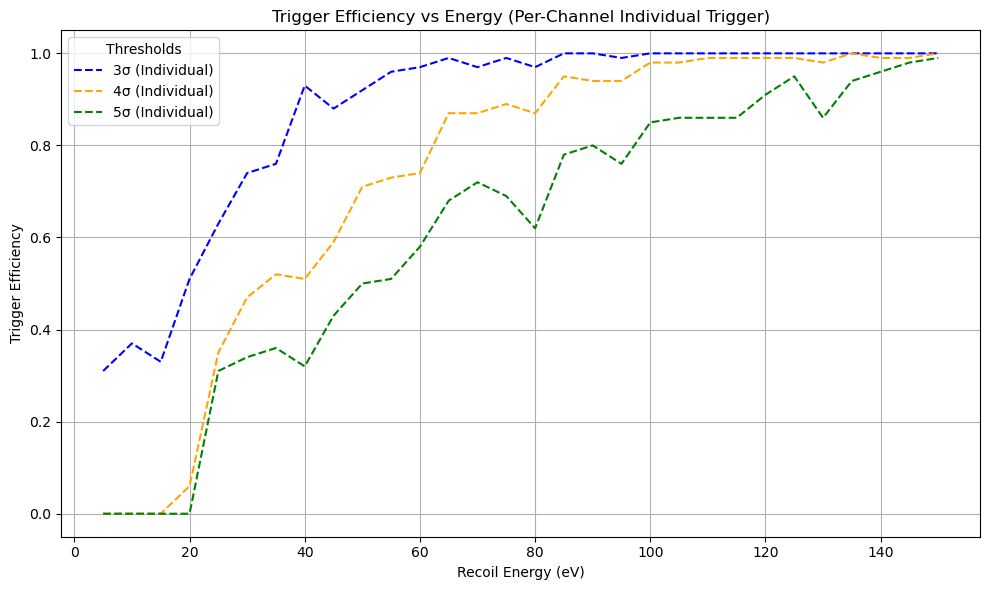

In [1]:
import trace_IO as tio
import OF_trigger as of
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zstandard as zstd
import io

# Constants
sampling_frequency = 3906250
sigma_ch0_44 = 0.7674
sigma_ch45 = 0.8494
sigma_ch46plus = 0.7605

thresholds = [3, 4, 5]
energy_values = list(range(5, 151, 5))

sigma_labels = {
    3: '3σ',
    4: '4σ',
    5: '5σ'
}

# Load templates and PSDs
template_std = np.load("../templates/template_K_alpha_no_baseline.npy")
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize filters
OF_std = of.OFtrigger(template_std, noise_psd, sampling_frequency)
OF_ch45 = of.OFtrigger(ch45_template, noise_psd, sampling_frequency)
OF_ch46 = of.OFtrigger(ch46_template, noise_psd, sampling_frequency)

# Storage
pass_rates = {n: [] for n in thresholds}

# Main loop
for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces = tio.load_traces_from_zstd(trace_path, n_traces=100)  # shape: (100, 54, 32768)

    max_amplitudes = []

    for i in range(100):
        traces = loaded_traces[i]  # (54, 32768)
        amps = []

        for ch, trace in enumerate(traces):
            if ch <= 44:
                amp, *_ = OF_std.fit_with_shift(trace)
            elif ch == 45:
                amp, *_ = OF_ch45.fit_with_shift(trace)
            else:
                amp, *_ = OF_ch46.fit_with_shift(trace)
            amps.append(amp)

        max_amplitudes.append(max(amps))

    max_amplitudes = np.array(max_amplitudes)

    for n in thresholds:
        # Use minimum sigma for conservative thresholding
        threshold = max(n * sigma_ch0_44, n * sigma_ch45, n * sigma_ch46plus)
        pass_rate = np.sum(max_amplitudes > threshold) / 100
        pass_rates[n].append(pass_rate)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']

for i, n in enumerate(thresholds):
    plt.plot(energy_values, pass_rates[n], linestyle='--', color=colors[i], label=f'{sigma_labels[n]} (Individual)')

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Trigger Efficiency')
plt.title('Trigger Efficiency vs Energy (Per-Channel Individual Trigger)')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()
